<a href="https://colab.research.google.com/github/MarioBonse/Sketch-rnn/blob/master/train_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install --upgrade --quiet tensorflow-gpu
!pip install --upgrade --quiet PyDrive
!pip install -U tensorboardcolab
!pip install svgwrite

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


In [1]:
!git clone https://github.com/MarioBonse/Sketch-rnn.git
import os
os.chdir("Sketch-rnn")

Cloning into 'Sketch-rnn'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 189 (delta 2), reused 6 (delta 0), pack-reused 179
Receiving objects: 100% (189/189), 344.17 MiB | 32.69 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [3]:
import data_Manager 
from HyperParameters import HP
import keras
import matplotlib.pyplot as plt
from train import *

import tensorflow as tf
import draw

#tbc=TensorBoardColab()
HP.data_folder = "data/"
HP.data_name = "carrot.npz"
HP.data_location = "data/carrot.npz"
datas = data_Manager.Data()

# create the callback for data augmentaion during training
train_generator = data_Manager.DataGenerator(datas.train)
validation_encoder = datas.valid
validation_decoder = data_Manager.create_decoder_input(validation_encoder)
vaidation = [validation_encoder, validation_decoder]
HP.epochs = 20




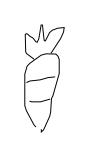

In [4]:
draw.draw_strokes(datas.train[0], svg_filename="carrot.svg")

In [5]:
"""
Create the model

1. ENCODER
"""
encoder_input = tf.keras.layers.Input(batch_shape = (HP.batch_size, None, HP.input_dimention), name = "encoder_input" )

encoderLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HP.enc_hidden_size, return_sequences=False,
    recurrent_dropout=HP.rec_dropout, name = "LSTM_encoder"), merge_mode='concat', name = "BI_LSTM_encoder")(encoder_input)

hidden_state_mean = tf.keras.layers.Dense(HP.latent_dim, activation='linear', name = "mean_MLP")(encoderLSTM)

variance_hat = tf.keras.layers.Dense(HP.latent_dim, activation='linear', name = "variance_MLP")(encoderLSTM)

# from mean and variance to latent vairable z
z = tf.keras.layers.Lambda(sampling, output_shape=(HP.latent_dim,), name='z')([hidden_state_mean, variance_hat])

# create the model with keras
encoder = tf.keras.models.Model(encoder_input, [hidden_state_mean, variance_hat, z], name='encoder')
encoder.summary()
#tf.keras.utils.plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

""" 
DECODER 
"""
# the decoder LSTM has an input composed by the sequence and also the hidden state
decoder_input_sequence = tf.keras.layers.Input(batch_shape = (HP.batch_size, HP.max_seq_length, HP.input_dimention), name = "decoder_seq_input" )
# we have also the latent variable as input of the LSTM with the sequence
inputLatentVariable = tf.keras.layers.RepeatVector(HP.max_seq_length)(z)
# so we concatentate the two vector
# as input we have the two vector above concatenated
totalInput = tf.keras.layers.Concatenate()([decoder_input_sequence, inputLatentVariable])
# Create LSTM for generation with input state = tanh(z)
decoderLSTM = tf.keras.layers.LSTM(HP.dec_hidden_size, recurrent_dropout=HP.rec_dropout, 
                                    return_sequences=True, return_state=True, name = "LSTM_decoder")
#

I0000 00:00:1721581522.963176  264367 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721581522.987606  264367 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721581522.987831  264367 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721581522.992009  264367 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721581522.992093  264367 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (100, None, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BI_LSTM_encoder     │ (100, 512)        │    536,576 │ encoder_input[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_MLP (Dense)    │ (100, 256)        │    131,328 │ BI_LSTM_encoder[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variance_MLP        │ (100, 256)        │    131,328 │ BI_LSTM_encoder[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (100, 256)        │          0 │ mean_MLP[0][0],   │
│                     │                   │            │ variance_MLP[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 799,232 (3.05 MB)

 Trainable params: 799,232 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
init_state = tf.keras.layers.Dense(units=(2*decoderLSTM.units), activation='tanh', name = "decoder_init_stat")(z)

In [7]:
init_state

<KerasTensor shape=(100, 1024), dtype=float32, sparse=False, name=keras_tensor_6>

In [8]:
# thanks chatgpt
h_0, c_0 = tf.keras.layers.Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=1))(init_state)

In [9]:
# creation of the LSTM
decoder_output, _, _ = decoderLSTM(totalInput, initial_state = [h_0, c_0])

# dense to output. THe dimention is, as explained in the paper equal to 3 + 6*M
# 6 times M= number of mixture 
output_dimention = (3 + HP.M * 6)
distribution_output = tf.keras.layers.Dense(output_dimention, name = "output_layer")(decoder_output)

# Build Keras model
seq_to_seq_VAE = tf.keras.models.Model([encoder_input, decoder_input_sequence], distribution_output)
seq_to_seq_VAE.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (100, None, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BI_LSTM_encoder     │ (100, 512)        │    536,576 │ encoder_input[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_MLP (Dense)    │ (100, 256)        │    131,328 │ BI_LSTM_encoder[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variance_MLP        │ (100, 256)        │    131,328 │ BI_LSTM_encoder[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (100, 256)        │          0 │ mean_MLP[0][0],   │
│                     │                   │            │ variance_MLP[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_seq_input   │ (100, 200, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (100, 200, 256)   │          0 │ z[0][0]           │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_init_stat   │ (100, 1024)       │    263,168 │ z[0][0]           │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (100, 200, 261)   │          0 │ decoder_seq_inpu… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ [(100, 512),      │          0 │ decoder_init_sta… │
│                     │ (100, 512)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_decoder (LSTM) │ [(100, 200, 512), │  1,585,152 │ concatenate[0][0… │
│                     │ (100, 512), (100, │            │ lambda[0][0],     │
│                     │ 512)]             │            │ lambda[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (100, 200, 123)   │     63,099 │ LSTM_decoder[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,710,651 (10.34 MB)

 Trainable params: 2,710,651 (10.34 MB)

 Non-trainable params: 0 (0.00 B)

Define the loss

In [10]:
    KL_weight = tf.keras.backend.variable(0.01, name = 'kl_weight')
    KL_wheight_schedule = data_Manager.changing_KL_wheight(KL_weight)
    def vae_loss(y_true, y_pred):
        """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
        # E[log P(X|z)]
        recon = reconstruction_loss(y_true, y_pred)
        # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
        kl = kl_loss(hidden_state_mean, variance_hat)

        return recon + kl*KL_weight

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate = HP.lr, clipvalue= HP.grad_clip)
seq_to_seq_VAE.compile(optimizer=optimizer,  loss = vae_loss)


In [12]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


I0000 00:00:1721581523.551307  264367 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721581523.551356  264367 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721581523.551376  264367 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721581523.551485  264367 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 01:05:23.551497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2112] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.

In [13]:
output_signature = ((
  tf.TensorSpec(shape=(HP.batch_size, HP.max_seq_length, HP.input_dimention), dtype=tf.float32),
  tf.TensorSpec(shape=(HP.batch_size, HP.max_seq_length, HP.input_dimention), dtype=tf.float32),
), 
  tf.TensorSpec(shape=(HP.batch_size, HP.max_seq_length, HP.input_dimention), dtype=tf.float32),
)

In [14]:
with tf.device('/device:GPU:0'):
  train_dataset = tf.data.Dataset.from_generator(lambda: train_generator, output_signature=output_signature)
  validation_dataset = tf.data.Dataset.from_generator(lambda: validation_generator, output_signature=output_signature)
  history = seq_to_seq_VAE.fit(
                       train_dataset,
                       # validation_data= ([validation_encoder, validation_decoder],[validation_encoder]),
                       validation_data=validation_dataset,
                       steps_per_epoch=(datas.trainDimention)//HP.batch_size, 
                       epochs=HP.epochs, 
                       callbacks=[KL_wheight_schedule])
# save the model
seq_to_seq_VAE.save_weights("model_weight_carrot_20_epochs.h5")

Epoch 1/20


ValueError: A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Plot the history

dict_keys(['loss', 'val_loss'])


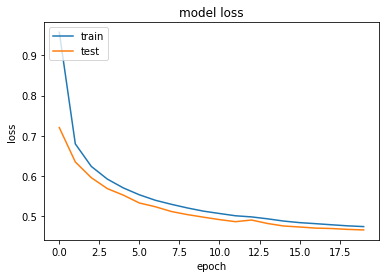

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
seq_to_seq_VAE.load_weights("model_weight_carrot_20_epochs.h5", by_name = True)


In [ ]:
HP.epocs = 50
with tf.device('/device:GPU:0'):
  history = seq_to_seq_VAE.fit_generator(train_generator,
                       validation_data= ([validation_encoder, validation_decoder],[validation_encoder]),
                       steps_per_epoch=(datas.trainDimention)/HP.batch_size, 
                       epochs=50, 
                       callbacks=[KL_wheight_schedule], initial_epoch = 20)
# save the model
seq_to_seq_VAE.save_weights("model_weight_carrot_50_epochs.h5")


W0826 16:55:22.563134 139747641997184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 21/50
700/700 [==============================] - 885s 1s/step - loss: 0.4881 - val_loss: 0.4952
Epoch 22/50
700/700 [==============================] - 883s 1s/step - loss: 0.4862 - val_loss: 0.4939
Epoch 23/50
700/700 [==============================] - 882s 1s/step - loss: 0.4849 - val_loss: 0.4934
Epoch 24/50
700/700 [==============================] - 883s 1s/step - loss: 0.4836 - val_loss: 0.4920
Epoch 25/50
700/700 [==============================] - 885s 1s/step - loss: 0.4824 - val_loss: 0.4916
Epoch 26/50
700/700 [==============================] - 882s 1s/step - loss: 0.4815 - val_loss: 0.4905
Epoch 27/50
700/700 [==============================] - 881s 1s/step - loss: 0.4804 - val_loss: 0.4895
Epoch 28/50
700/700 [==============================] - 883s 1s/step - loss: 0.4794 - val_loss: 0.4890
Epoch 29/50
700/700 [==============================] - 880s 1s/step - loss: 0.4787 - val_loss: 0.4888
Epoch 30/50
700/700 [==============================] - 882s 1s/step - loss: 0.4779

dict_keys(['loss', 'val_loss'])


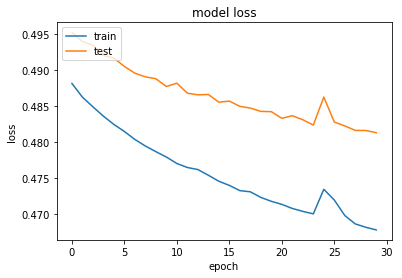

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()